In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

from datetime import datetime
from UnetModel import *

%matplotlib inline

Using TensorFlow backend.


In [2]:
#Load pre-trained model
base_model=VGG16(weights='imagenet',include_top=False) #imports the vgg16 model and discards the last 1000 neuron layer.


for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output

bottom_conv = Conv2D(1024, (3, 3), padding="same")(x)
bottom_acti = LeakyReLU(alpha=0.001)(bottom_conv)
bottom_conv = Conv2D(1024, (3, 3), padding="same")(bottom_acti)
bottom_acti = LeakyReLU(alpha=0.001)(bottom_conv)

# 14 x 14 block5
left_block5 = base_model.get_layer('block5_conv3').output
right_up5 = concatenate([UpSampling2D(size=(2, 2))(bottom_acti), left_block5], axis=3)
right_conv5 = Conv2D(512, (3, 3), padding="same")(right_up5)
right_acti5 = LeakyReLU(alpha=0.001)(right_conv5)
right_conv5 = Conv2D(512, (3, 3), padding="same")(right_acti5)
right_acti5 = LeakyReLU(alpha=0.001)(right_conv5)

# 28 x 28 block4
left_block4 = base_model.get_layer('block4_conv3').output
right_up4 = concatenate([UpSampling2D(size=(2, 2))(right_acti5), left_block4], axis=3)
right_conv4 = Conv2D(512, (3, 3), padding="same")(right_up4)
right_acti4 = LeakyReLU(alpha=0.001)(right_conv4)
right_conv4 = Conv2D(512, (3, 3), padding="same")(right_acti4)
right_acti4 = LeakyReLU(alpha=0.001)(right_conv4)

# 56 x 56 block3
left_block3 = base_model.get_layer('block3_conv3').output
right_up3 = concatenate([UpSampling2D(size=(2, 2))(right_acti4), left_block3], axis=3)
right_conv3 = Conv2D(256, (3, 3), padding="same")(right_up3)
right_acti3 = LeakyReLU(alpha=0.001)(right_conv3)
right_conv3 = Conv2D(256, (3, 3), padding="same")(right_acti3)
right_acti3 = LeakyReLU(alpha=0.001)(right_conv3)

# 112 x 112 block2
left_block2 = base_model.get_layer('block2_conv2').output
right_up2 = concatenate([UpSampling2D(size=(2, 2))(right_acti3), left_block2], axis=3)
right_conv2 = Conv2D(128, (3, 3), padding="same")(right_up2)
right_acti2 = LeakyReLU(alpha=0.001)(right_conv2)
right_conv2 = Conv2D(128, (3, 3), padding="same")(right_acti2)
right_acti2 = LeakyReLU(alpha=0.001)(right_conv2)

# 224 x 224 block1
left_block1 = base_model.get_layer('block1_conv2').output
right_up1 = concatenate([UpSampling2D(size=(2, 2))(right_acti2), left_block1], axis=3)
right_conv1 = Conv2D(64, (3, 3), padding="same")(right_up1)
right_acti1 = LeakyReLU(alpha=0.001)(right_conv1)
right_conv1 = Conv2D(64, (3, 3), padding="same")(right_acti1)
right_acti1 = LeakyReLU(alpha=0.001)(right_conv1)


#Sigmoid
output = Conv2D(1, (1, 1), activation='sigmoid')(right_acti1)
model = Model(input=base_model.input, output=output)

model.compile(optimizer=Adam(lr=1e-5), loss=jaccard_coef_loss, metrics=[jaccard_coef])


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 10s 0us/step


C:\Users\li_ni\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [ ]:
img_rows = 224
img_cols = 224

data_gen_args = dict(
#    samplewise_center = True,
#    samplewise_std_normalization = True,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode='nearest')

#Validation data generation
data_val_gen_args = dict(
    #samplewise_center = True,
    #samplewise_std_normalization = True
    )

#Setup generator
batch_size = 6
      
myGene = trainGenerator(batch_size,'data/train','images','masks',data_gen_args, target_size= (img_rows,img_rows))
myValGene = validationGenerator(batch_size,'data/val','images','masks',data_val_gen_args, target_size= (img_rows,img_rows))

#Create folder for models
date_object = datetime.now()
# convert object to the format we want
formatted_date = date_object.strftime('%Y%m%d')
output_dir = 'unet/{}'.format(formatted_date)
os.makedirs(output_dir, exist_ok =True)

#Setup Checkpoint to only capture best estimate
model_checkpoint = ModelCheckpoint('{}/unet_lesion_{}_{{epoch:03d}}-{{val_jaccard_coef:.5f}}.hdf5'.format(output_dir, formatted_date)
                                   , monitor='val_jaccard_coef'
                                   ,verbose=1, mode='max', save_best_only=True)

iterations = 100
#Train
history = model.fit_generator(
    myGene,
    steps_per_epoch = 300, 
    epochs=iterations,
    callbacks=[model_checkpoint],
    validation_data=myValGene,
    validation_steps=100)

model.save(os.path.join(output_dir, 'iter_{}'.format(iterations)))

Epoch 1/100
Found 519 images belonging to 1 classes.
Found 1555 images belonging to 1 classes.
Found 519 images belonging to 1 classes.
Found 1555 images belonging to 1 classes.
300/300 [==============================] - 551s 2s/step - loss: -0.6085 - jaccard_coef: 0.6085 - val_loss: -0.7139 - val_jaccard_coef: 0.7139

Epoch 00001: val_jaccard_coef improved from -inf to 0.71390, saving model to unet/20190523/unet_lesion_20190523_001-0.71390.hdf5
Epoch 2/100
262/300 [=========================>....] - ETA: 52s - loss: -0.7004 - jaccard_coef: 0.7004

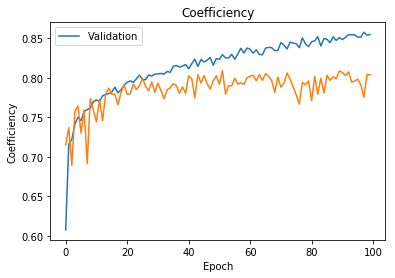

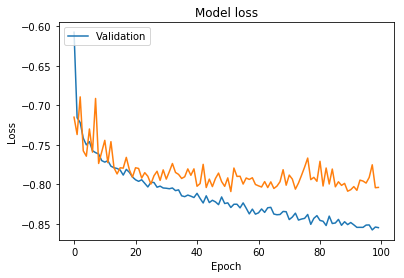

In [6]:
# Plot training & validation accuracy values
plt.plot(history.history['jaccard_coef'])
plt.plot(history.history['val_jaccard_coef'])
plt.title('Coefficiency')
plt.ylabel('Coefficiency')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.legend(['Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.legend(['Validation'], loc='upper left')
plt.show()

In [8]:
coef = np.array(history.history['jaccard_coef'])
val_coef = np.array(history.history['val_jaccard_coef'])
print("Training co-effiency    : {};\nValidation co-effiency : {}".format(coef[coef==max(coef)][0], val_coef[np.argmax(coef)]))


Training co-effiency    : 0.8577200777370837;
Validation co-effiency : 0.7753131805951871


In [24]:
model.load_weights("unet/20190519/unet_lesion_20190519_059-0.80857.hdf5")

file_names = next(os.walk(test_data_dir))[2]
scores = []
for file in file_names:
    grey_img = load_img(os.path.join(test_data_dir,file), target_size=(img_rows, img_cols), grayscale=False)
    mask_img = load_img(os.path.join(test_data_mask_dir,file.split('.')[0]+"_segmentation.png"), 
                        target_size=(img_rows, img_cols), grayscale=True)
    img = img_to_array(grey_img)
    img_mask = img_to_array(mask_img)
    
    #Preprocess image mask
    #img_mask = img_mask /255
    #img_mask[img_mask > 0.5] = 1
    #img_mask[img_mask <= 0.5] = 0
    #Preprocess images
    #mean = np.mean(img)  # mean for data centering
    #std = np.std(img)  # std for data normalization
    #img -= mean
    #img /= std
    img, img_mask = normalizeData(img, img_mask)
    img = np.reshape(img,(1,)+img.shape)
    
    
    
    pred = model.predict([img])
    sess = tf.Session()
    score = sess.run(jaccard_coef(img_mask, pred))
    print("{} -- jaccard index: {}".format(file,score))
    scores.append([file,score])

    result_img = array_to_img(pred[0] * 255 )
    result_img.save(os.path.join(test_data_pred_dir, file.split('.')[0] + '_predict.jpg'))

with open("unet_test_result.csv", 'w') as f:
    f.write("filename, jaccard_index\n")
    for i in range(len(scores)):
        #print(scores[i])
        f.write("{},{}\n".format(scores[i][0], scores[i][1]))

ISIC_0015208.jpg -- jaccard index: 0.9540793895721436
ISIC_0014110.jpg -- jaccard index: 0.9293732047080994
ISIC_0015207.jpg -- jaccard index: 0.7073414921760559
ISIC_0009951.jpg -- jaccard index: 0.802521288394928
ISIC_0000365.jpg -- jaccard index: 0.9101837277412415
ISIC_0014092.jpg -- jaccard index: 0.8402589559555054
ISIC_0014855.jpg -- jaccard index: 0.8161075115203857
ISIC_0011166.jpg -- jaccard index: 0.7711727023124695
ISIC_0010599.jpg -- jaccard index: 0.9396867752075195
ISIC_0000484.jpg -- jaccard index: 0.8141406774520874
ISIC_0010474.jpg -- jaccard index: 0.9415503144264221
ISIC_0012706.jpg -- jaccard index: 0.2480030655860901
ISIC_0010067.jpg -- jaccard index: 0.831932544708252
ISIC_0015229.jpg -- jaccard index: 0.7654320597648621
ISIC_0015568.jpg -- jaccard index: 0.8696528077125549
ISIC_0015973.jpg -- jaccard index: 0.9210171103477478
ISIC_0012713.jpg -- jaccard index: 0.7089471220970154
ISIC_0015152.jpg -- jaccard index: 0.6779975295066833
ISIC_0012216.jpg -- jaccard in

ISIC_0015593.jpg -- jaccard index: 0.5978150963783264
ISIC_0000421.jpg -- jaccard index: 0.9157114028930664
ISIC_0012487.jpg -- jaccard index: 0.6873704195022583
ISIC_0007156.jpg -- jaccard index: 0.8383557796478271
ISIC_0015160.jpg -- jaccard index: 0.883951723575592
ISIC_0001212.jpg -- jaccard index: 0.7598267793655396
ISIC_0003805.jpg -- jaccard index: 0.8020504117012024
ISIC_0015607.jpg -- jaccard index: 0.5557745695114136
ISIC_0010584.jpg -- jaccard index: 0.7625454664230347
ISIC_0013189.jpg -- jaccard index: 0.5874019861221313
ISIC_0000228.jpg -- jaccard index: 0.9561255574226379
ISIC_0000047.jpg -- jaccard index: 0.8872924447059631
ISIC_0011109.jpg -- jaccard index: 0.8685506582260132
ISIC_0000486.jpg -- jaccard index: 0.9509697556495667
ISIC_0012680.jpg -- jaccard index: 0.940122127532959
ISIC_0014805.jpg -- jaccard index: 0.906254768371582
ISIC_0008998.jpg -- jaccard index: 0.8833758234977722
ISIC_0013249.jpg -- jaccard index: 0.7694524526596069
ISIC_0000510.jpg -- jaccard ind

ISIC_0005548.jpg -- jaccard index: 0.9193066358566284
ISIC_0010219.jpg -- jaccard index: 0.8039007186889648
ISIC_0012969.jpg -- jaccard index: 0.7094855308532715
ISIC_0011135.jpg -- jaccard index: 0.9212905168533325
ISIC_0001188.jpg -- jaccard index: 0.8130499720573425
ISIC_0011301.jpg -- jaccard index: 0.9427648782730103
ISIC_0015040.jpg -- jaccard index: 0.6441420316696167
ISIC_0013203.jpg -- jaccard index: 0.6381925344467163
ISIC_0007332.jpg -- jaccard index: 0.8561199307441711
ISIC_0001118.jpg -- jaccard index: 0.9365506172180176
ISIC_0010255.jpg -- jaccard index: 0.8826594948768616
ISIC_0011101.jpg -- jaccard index: 0.9423109889030457
ISIC_0009918.jpg -- jaccard index: 0.8001259565353394
ISIC_0010335.jpg -- jaccard index: 0.891241192817688
ISIC_0009758.jpg -- jaccard index: 0.8422152996063232
ISIC_0016025.jpg -- jaccard index: 0.730634868144989
ISIC_0013403.jpg -- jaccard index: 0.9313302636146545
ISIC_0000200.jpg -- jaccard index: 0.8109307885169983
ISIC_0010861.jpg -- jaccard in

ISIC_0000204.jpg -- jaccard index: 0.9342555999755859
ISIC_0012840.jpg -- jaccard index: 0.9095937609672546
ISIC_0016037.jpg -- jaccard index: 0.8352704644203186
ISIC_0014410.jpg -- jaccard index: 0.447541743516922
ISIC_0012201.jpg -- jaccard index: 0.9444417953491211
ISIC_0013690.jpg -- jaccard index: 0.6413149833679199
ISIC_0013972.jpg -- jaccard index: 0.7116392850875854
ISIC_0006021.jpg -- jaccard index: 0.8812286853790283
ISIC_0012164.jpg -- jaccard index: 0.8187234401702881
ISIC_0015212.jpg -- jaccard index: 0.930644690990448
ISIC_0014726.jpg -- jaccard index: 0.690467357635498
ISIC_0000313.jpg -- jaccard index: 0.899148166179657
ISIC_0000370.jpg -- jaccard index: 0.8962568640708923
ISIC_0015034.jpg -- jaccard index: 0.9662836790084839
ISIC_0001191.jpg -- jaccard index: 0.8642525672912598
ISIC_0011202.jpg -- jaccard index: 0.8924583196640015
ISIC_0013109.jpg -- jaccard index: 0.9191377758979797
ISIC_0000247.jpg -- jaccard index: 0.8675437569618225
ISIC_0010321.jpg -- jaccard inde

In [15]:
def jaccard_index_log_loss(y_true, y_pred):
    j = -K.log(jaccard_coef(y_true, y_pred))
    #l = - np.power(1-j, 1) * K.log(j)
    return j

In [22]:
model.compile(optimizer=Adam(lr=5e-6), loss='categorical_crossentropy', metrics=[jaccard_coef,'acc'])

In [23]:
history2 = model.fit_generator(
    myGene,
    steps_per_epoch = 300, 
    epochs=200,
    callbacks=[model_checkpoint], 
    initial_epoch = 93,
    validation_data=myValGene,
    validation_steps=100)

Epoch 94/200


ValueError: You are passing a target array of shape (6, 224, 224, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

In [ ]:
#This code combined 2 seperate training history together and plot the result
hist = {}
for i in history.history.keys():
    hist_concate = np.array([np.array(history.history[i]), np.array(history2.history[i])]).flatten() 
    hist[i] = hist_concate
# Plot training & validation accuracy values
plt.plot(hist['jaccard_coef'])
plt.plot(hist['val_jaccard_coef'])
plt.title('Coefficiency')
plt.ylabel('Coefficiency')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.legend(['Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.legend(['Validation'], loc='upper left')
plt.show()

coef = np.array(hist['jaccard_coef'])
val_coef = np.array(hist['val_jaccard_coef'])
print("Training co-effiency    : {};\nValidation co-effiency : {}".format(coef[coef==max(coef)][0], val_coef[np.argmax(coef)]))
